In [5]:
# NB need to use environment with python3.9 or above for ccf_streamlines to run
import nrrd
import numpy as np
import matplotlib.pyplot as plt
import ccf_streamlines.projection as ccfproj
import pathlib
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import LogNorm
import copy
import seaborn as sb
import nrrd
#from preprocessing_sequencing import preprocess_sequences as ps
from bg_atlasapi import BrainGlobeAtlas
#from final_processing import final_processing_functions as fpf
import additional_functions as af
import ast
import yaml
from scipy.ndimage import zoom
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
%matplotlib inline


In [4]:
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
roi_dict = {}
sample_vol_and_regions = {}
parameters_dict = {}
barcodes_dict = {}
scaling_factor = 25 / 10  # since we need in 10um resolution, we need to convert 25um resolution registered cubelets to 10um
zoom_factors = (scaling_factor, scaling_factor, scaling_factor)
for mouse in mice:
    lcm_directory = pathlib.Path(
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/LCM"
    )
    # load datasets
    barcodes_across_sample = pd.read_pickle(
        f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/A1_barcodes_thresholded_with_source.pkl"
    )
    barcodes_dict[mouse] = barcodes_across_sample[barcodes_across_sample.sum(axis=1)>0]
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    not_in = [x for x in np.unique(ROI_3D) if x not in barcodes_across_sample.columns and x != 0]
    ROI_3D[np.isin(ROI_3D, not_in)] = 0
    sample_vol_and_regions[mouse] =pd.read_pickle(lcm_directory/'sample_vol_and_regions.pkl')
    parameters_dict[mouse] = af.load_parameters(directory=f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/")
    mask = np.isin(ROI_3D, parameters_dict[mouse]['cortical_samples'])
    ROI_3D[~mask] = 0
    roi_dict[mouse] = zoom(ROI_3D, zoom=zoom_factors, order=0)
    # A1 = sample_vol_and_regions[sample_vol_and_regions['main']=='AUDp']['ROI Number'].to_list()
    # barcodes_across_sample = barcodes_across_sample[barcodes_across_sample.idxmax(axis=1).isin(A1)]
# this is the path to where the ccf streamlines downloads is (so don't change when looking a different mice)
convert_to_flat_path = pathlib.Path(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration"
)
annotation_data = nrrd.read("/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/flatmap_butterfly.nrrd")
labels_df =  pd.read_csv(
            "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/labelDescription_ITKSNAPColor.txt",
            header=None,
            sep="\s+",
            index_col=0
        )
labels_df.columns = ["r", "g", "b", "x0", "x1", "x2", "acronym"]
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=convert_to_flat_path / "flatmap_butterfly.nrrd",
    labels_file=convert_to_flat_path / "labelDescription_ITKSNAPColor.txt",
)

# We get the left hemisphere region boundaries with the default arguments
bf_left_boundaries = bf_boundary_finder.region_boundaries()

# And we can get the right hemisphere boundaries that match up with
# our projection if we specify the same configuration
bf_right_boundaries = bf_boundary_finder.region_boundaries(
    # we want the right hemisphere boundaries, but located in the right place
    # to plot both hemispheres at the same time
    hemisphere="right_for_both",
    # we also want the hemispheres to be adjacent
    view_space_for_other_hemisphere="flatmap_butterfly",
)
proj_top = ccfproj.Isocortex2dProjector(
    # Specify our view lookup file
    convert_to_flat_path / "flatmap_butterfly.h5",
    # Specify our streamline file
    convert_to_flat_path / "surface_paths_10_v3.h5",
    # Specify that we want to project both hemispheres
    hemisphere="both",
    # The top view contains space for the right hemisphere, but is empty.
    # Therefore, we tell the projector to put both hemispheres side-by-side
    view_space_for_other_hemisphere="flatmap_butterfly",
)

ref_anno = nrrd.read('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/LCM_registration/reference/annotation_25.nrrd')
allen_anno = np.array(ref_anno)
annotation = allen_anno[0]

loading path information


100%|██████████| 1016/1016 [00:06<00:00, 151.66it/s]
/tmp/ipykernel_3648963/3945506162.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  allen_anno = np.array(ref_anno)


/tmp/ipykernel_3648963/635403602.py:31: RuntimeWarning: divide by zero encountered in log10
  new_mat = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T
/tmp/ipykernel_3648963/635403602.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


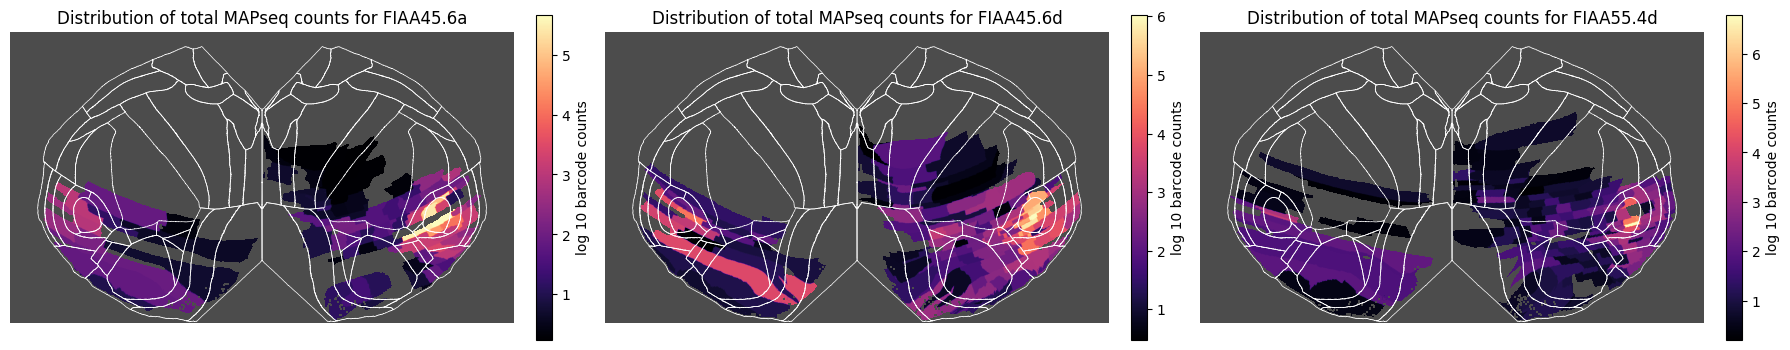

In [6]:
SSp_regions = []
# SSp_all_coords ={}
for key in bf_left_boundaries.keys():
    if 'SSp' in key:
        SSp_regions.append(str(key))
        # coords = bf_left_boundaries[key]
        # SSp_all_coords[key] = coords
new_left_bound_dict = {key: value for key, value in bf_left_boundaries.items() if key not in SSp_regions}    
new_right_bound_dict = {key: value for key, value in bf_right_boundaries.items() if key not in SSp_regions}    

all_mice_flat = {}
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
for ax, mouse in zip(axes, mice):
    # Access barcodes across sample for the current mouse
    ROI_projection_max = proj_top.project_volume(roi_dict[mouse])
    barcodes_across_sample = barcodes_dict[mouse] 
    barcode_matrix = np.zeros(
        (
            len(barcodes_across_sample),
            int(max(barcodes_across_sample.columns.to_list())) + 1,
        )
    )
    
    # Fill the barcode matrix
    for column in barcodes_across_sample:
        barcode_matrix[:, int(column)] = barcodes_across_sample[column].to_numpy()
    
    # Calculate total counts and set zero values to -1
    total_counts = np.sum(barcode_matrix, axis=0)
    total_counts[0] = -1
    new_mat = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T
    all_mice_flat[mouse] = new_mat
    # Set up the color map
    cmap = plt.cm.get_cmap("magma").copy()
    cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # Set NaN values as grey

    # Plot the heatmap on the current axis
    im = ax.imshow(new_mat, cmap=cmap)
    ax.axis("off")
    
    # Add color bar to each subplot
    fig.colorbar(im, ax=ax, label="log 10 barcode counts", fraction=0.03, pad=0.04)

    # Plot the boundaries for each side
    for k, boundary_coords in new_left_bound_dict.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)
    for k, boundary_coords in new_right_bound_dict.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)

    # Set the title for each subplot
    ax.set_title(f"Distribution of total MAPseq counts for {mouse}")

# Adjust layout to make space between subplots
plt.tight_layout()
plt.show()
# Save the figure with three subplots
#plt.savefig("/camp/lab/znamenskiyp/home/shared/code/MAPseq_processing/figs/MAPseq_bulk_counts.png", bbox_inches='tight', dpi=300)

# Clear the current figure to avoid overwriting or displaying
#plt.clf()

/tmp/ipykernel_3648963/1840503636.py:21: RuntimeWarning: divide by zero encountered in log10
  raw_data = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T
/tmp/ipykernel_3648963/1840503636.py:37: RuntimeWarning: Mean of empty slice
  mean_z_normalized = np.nanmean(all_mice_array, axis=0)
/tmp/ipykernel_3648963/1840503636.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


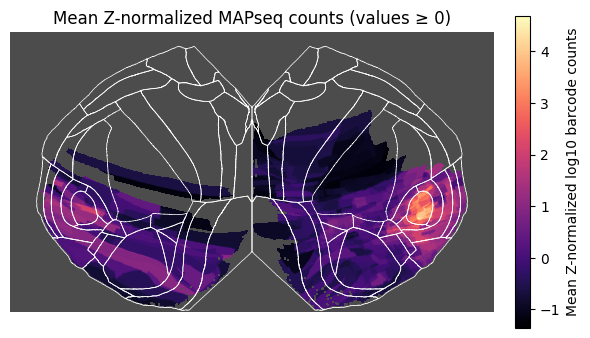

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Collect all z-normalized data
all_mice_normalized = []

# Iterate through mice and z-normalize data
for mouse in mice:
    ROI_projection_max = proj_top.project_volume(roi_dict[mouse])
    barcodes_across_sample = barcodes_dict[mouse] 
    barcode_matrix = np.zeros(
        (
            len(barcodes_across_sample),
            int(max(barcodes_across_sample.columns.to_list())) + 1,
        )
    )
    for column in barcodes_across_sample:
        barcode_matrix[:, int(column)] = barcodes_across_sample[column].to_numpy()
    total_counts = np.sum(barcode_matrix, axis=0)
    total_counts[0] = -1
    raw_data = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T

    # Z-normalize the data
    valid_data = raw_data[raw_data >= 0]  # Include only values ≥ 0
    mean = np.mean(valid_data)
    std = np.std(valid_data)
    z_normalized = (raw_data - mean) / std
    z_normalized[raw_data < 0] = np.nan  # Set invalid values to NaN for exclusion

    # Append z-normalized data
    all_mice_normalized.append(z_normalized)

# Convert list to array and compute the mean across mice
all_mice_array = np.stack(all_mice_normalized, axis=0)

# Compute mean while ignoring NaNs
mean_z_normalized = np.nanmean(all_mice_array, axis=0)

# Plot the z-normalized mean data
fig, ax = plt.subplots(figsize=(6, 6))

# Set up the color map
cmap = plt.cm.get_cmap("magma").copy()
cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # Set NaN values as grey

# Plot the heatmap
im = ax.imshow(mean_z_normalized, cmap=cmap)
ax.axis("off")

# Add color bar
fig.colorbar(im, ax=ax, label="Mean Z-normalized log10 barcode counts", fraction=0.03, pad=0.04)

# Plot the boundaries
for k, boundary_coords in new_left_bound_dict.items():
    ax.plot(*boundary_coords.T, c="white", lw=0.5)
for k, boundary_coords in new_right_bound_dict.items():
    ax.plot(*boundary_coords.T, c="white", lw=0.5)

# Set the title
ax.set_title("Mean Z-normalized MAPseq counts (values ≥ 0)")

# Adjust layout
plt.tight_layout()
plt.show()

# Save the figure
# plt.savefig("/camp/lab/znamenskiyp/home/shared/code/MAPseq_processing/figs/MAPseq_mean_z_normalized_counts.png", bbox_inches='tight', dpi=300)


In [11]:
np.unique(mean_z_normalized)

array([nan])